## III. Feature selection, algorithm improvement

In this notebook, I shall run improve the best model from the preivous notebook (Random Forest Classificator) by undertaking the following steps:
    - Feature selection (hybrid recursive feature addition)
    - Tune hyper paramters

Then I shall check and prove the improvement.

Finally, I shall the Confusion Metrics and ROC Curve graph

### 1 Importing libraries

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score



%matplotlib inline
%matplotlib inline

### 2. Import datasets 

In [2]:
# Merge the two datasets
df=pd.read_csv('dfprepared.csv')
df.shape

(937, 36)

### 3. Model creation & data balancing 

#### 3.1 Model Creation

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['CreditStatus'], axis=1),
    df['CreditStatus'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((655, 35), (282, 35))

#### 3.2 Smote for data imbalance

In [4]:
train_input = X_train
train_output = y_train


In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({1: 369, 0: 286})
New dataset shape Counter({1: 369, 0: 369})


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Now both outcomes of the label are balanced

### 4. Feature selection (hybrid method: recursive addition)

In [6]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = RandomForestClassifier()

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features RFC ROC AUC=%f' % (auc_score_all))


Test all features RFC ROC AUC=0.872534


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


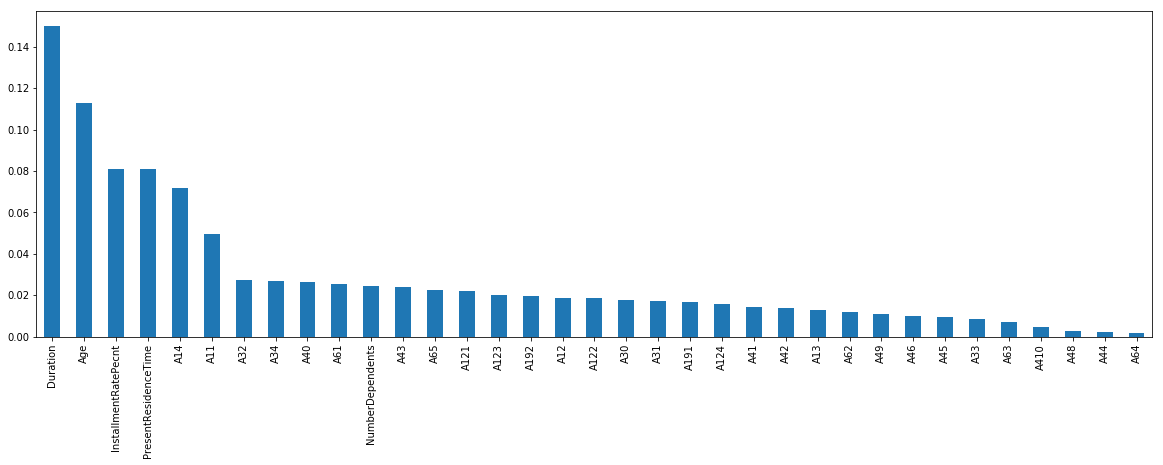

In [7]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['Duration',
 'Age',
 'InstallmentRatePecnt',
 'PresentResidenceTime',
 'A14',
 'A11',
 'A32',
 'A34',
 'A40',
 'A61',
 'NumberDependents',
 'A43',
 'A65',
 'A121',
 'A123',
 'A192',
 'A12',
 'A122',
 'A30',
 'A31',
 'A191',
 'A124',
 'A41',
 'A42',
 'A13',
 'A62',
 'A49',
 'A46',
 'A45',
 'A33',
 'A63',
 'A410',
 'A48',
 'A44',
 'A64']

In [9]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = RandomForestClassifier()

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature RFC ROC AUC=%f' % (auc_score_first))

Test one feature RFC ROC AUC=0.827976


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = RandomForestClassifier()

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  Age  which is feature  1  out of  35
New Test ROC AUC=0.7589695715799567
All features Test ROC AUC=0.8279759802190039
Increase in ROC AUC=-0.06900640863904717
remove:  Age

testing feature:  InstallmentRatePecnt  which is feature  2  out of  35
New Test ROC AUC=0.8495735984255942
All features Test ROC AUC=0.8279759802190039
Increase in ROC AUC=0.02159761820659034
keep:  InstallmentRatePecnt

testing feature:  PresentResidenceTime  which is feature  3  out of  35
New Test ROC AUC=0.8192461018317606
All features Test ROC AUC=0.8495735984255942
Increase in ROC AUC=-0.030327496593833603
remove:  PresentResidenceTime

testing feature:  A14  which is feature  4  out of  35
New Test ROC AUC=0.8249482767320988
All features Test ROC AUC=0.8495735984255942
Increase in ROC AUC=-0.024625321693495406
remove:  A14

testing feature:  A11  which is feature  5  out of  35
New Test ROC AUC=0.817530403189181
All features Test ROC AUC=0.8495735984255942


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test ROC AUC=0.8066306706363223
All features Test ROC AUC=0.8495735984255942
Increase in ROC AUC=-0.04294292778927189
remove:  A61

testing feature:  NumberDependents  which is feature  10  out of  35
New Test ROC AUC=0.8738204571832264
All features Test ROC AUC=0.8495735984255942
Increase in ROC AUC=0.024246858757632217
keep:  NumberDependents

testing feature:  A43  which is feature  11  out of  35
New Test ROC AUC=0.8481102084069234
All features Test ROC AUC=0.8738204571832264
Increase in ROC AUC=-0.025710248776303013
remove:  A43

testing feature:  A65  which is feature  12  out of  35
New Test ROC AUC=0.8747035373669072
All features Test ROC AUC=0.8738204571832264
Increase in ROC AUC=0.0008830801836807733
remove:  A65

testing feature:  A121  which is feature  13  out of  35
New Test ROC AUC=0.8558813140233134
All features Test ROC AUC=0.8738204571832264
Increase in ROC AUC=-0.017939143159913074
remove:  A121

testing feature:  A123  which is feature  14  out of  35
New Test R

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test ROC AUC=0.8576979361154564
All features Test ROC AUC=0.8738204571832264
Increase in ROC AUC=-0.016122521067770013
remove:  A30

testing feature:  A31  which is feature  19  out of  35
New Test ROC AUC=0.8830549528182873
All features Test ROC AUC=0.8738204571832264
Increase in ROC AUC=0.009234495635060846
keep:  A31

testing feature:  A191  which is feature  20  out of  35
New Test ROC AUC=0.8352676994499673
All features Test ROC AUC=0.8830549528182873
Increase in ROC AUC=-0.047787253368320015
remove:  A191

testing feature:  A124  which is feature  21  out of  35
New Test ROC AUC=0.8415249533229046
All features Test ROC AUC=0.8830549528182873
Increase in ROC AUC=-0.04152999949538272
remove:  A124

testing feature:  A41  which is feature  22  out of  35
New Test ROC AUC=0.86902659332896
All features Test ROC AUC=0.8830549528182873
Increase in ROC AUC=-0.014028359489327236
remove:  A41

testing feature:  A42  which is feature  23  out of  35
New Test ROC AUC=0.849018519452995
Al

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test ROC AUC=0.8632739567038401
All features Test ROC AUC=0.8830549528182873
Increase in ROC AUC=-0.01978099611444717
remove:  A46

testing feature:  A45  which is feature  28  out of  35
New Test ROC AUC=0.8850229600847757
All features Test ROC AUC=0.8830549528182873
Increase in ROC AUC=0.0019680072664883808
keep:  A45

testing feature:  A33  which is feature  29  out of  35
New Test ROC AUC=0.8532068426098804
All features Test ROC AUC=0.8850229600847757
Increase in ROC AUC=-0.03181611747489521
remove:  A33

testing feature:  A63  which is feature  30  out of  35
New Test ROC AUC=0.8651662713831558
All features Test ROC AUC=0.8850229600847757
Increase in ROC AUC=-0.01985668870161983
remove:  A63

testing feature:  A410  which is feature  31  out of  35
New Test ROC AUC=0.8767724680829591
All features Test ROC AUC=0.8850229600847757
Increase in ROC AUC=-0.0082504920018166
remove:  A410

testing feature:  A48  which is feature  32  out of  35
New Test ROC AUC=0.8657970429429278
All 

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

In [11]:
# capture the 5 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_rfc = RandomForestClassifier()

# fit the model with the selected features
final_rfc.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_rfc.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.877984


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We've reduce feature space from 35 to 5, and yet get the improved ROC AUC accuracy! See below:

In [12]:
print('Test all features RFC ROC AUC=%f' % (auc_score_all))
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('ROC AUC improvement',(auc_score_all-auc_score_final))

Test all features RFC ROC AUC=0.872534
Test selected features ROC AUC=0.877984
ROC AUC improvement -0.005449866276429405


### 5. Tune mode hyperparamters

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']


# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
from sklearn.ensemble import RandomForestClassifier
#making the instance
rfc=RandomForestClassifier()
# Random search of parameters
rfc_model = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_model.fit(X_train[features_to_keep], y_train)
# print results
print(rfc_model.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 240 is smaller than n_iter=300. Running 240 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.3min finished


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 140}


In [14]:
seed_val = 1000
np.random.seed(seed_val)

rfc2 = RandomForestClassifier(n_estimators=200, max_depth=140, max_features='sqrt')
rfc2.fit(X_train[features_to_keep],y_train)
rfc2_predict = rfc2.predict_proba(X_test[features_to_keep])[:, 1]

auc_score_final2 = roc_auc_score(y_test, rfc2_predict)
print('Test selected features ROC AUC=%f' % (auc_score_final2))





Test selected features ROC AUC=0.880002


**Check for improvement**

In [15]:
print ('Model ROC AUC improvement is',(auc_score_final2-auc_score_final))

Model ROC AUC improvement is 0.002018468991269895


If we remember that original model had an ROC AUC of 0.87, we've improved a lot as now the accuracy is 0.88, and with only 6 features (instead of 36)

**7.Save the model**

In [30]:
from sklearn.externals import joblib
from joblib import dump, load
dump(rfc2,'rfc2.joblib')  

['rfc2.joblib']

**7. Evidence that the model will generalize well**

In [18]:
import sklearn.metrics as sklm

labels = np.array(df['CreditStatus'])
probabilities = rfc2.predict_proba(X_test[features_to_keep])

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive       111                22
Actual negative        30               119

Accuracy  0.82
 
           Positive      Negative
Num case      133           149
Precision    0.79          0.84
Recall       0.83          0.80
F1           0.81          0.82


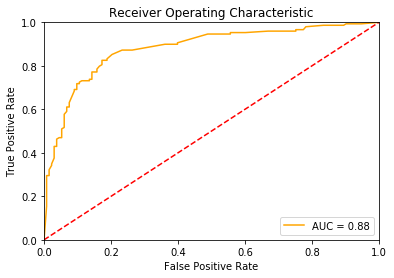

In [19]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)